# GRAPE calculation of control fields for single-qubit rotation

Robert Johansson (robert@riken.jp)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi

In [2]:
from qutip import *
from qutip.control import *

In [3]:
T = 1
times = np.linspace(0, T, 100)

In [4]:
theta, phi = np.random.rand(2)

In [5]:
from qutip.qip.operations import rx, rz

# target unitary transformation (random single qubit rotation)
U = rz(phi) * rx(theta); U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.94714831-0.30764815j -0.02808128-0.0864531j ]
 [ 0.02808128-0.0864531j   0.94714831+0.30764815j]]

In [6]:
R = 150
H_ops = [sigmax(), sigmay(), sigmaz()]

H_labels = [r'$u_{x}$',
            r'$u_{y}$',
            r'$u_{z}$',
        ]

In [7]:
H0 = 0 * pi * sigmaz()

# GRAPE

In [8]:
from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.cy_grape import cy_overlap
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive

In [9]:
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

In [10]:
u0 = np.array([np.random.rand(len(times)) * 2 * pi * 0.005 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

In [11]:
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2*pi/T, phase_sensitive=False,
                          progress_bar=TextProgressBar())

10.0%. Run time:   1.32s. Est. time left: 00:00:00:11
20.0%. Run time:   2.28s. Est. time left: 00:00:00:09
30.0%. Run time:   3.26s. Est. time left: 00:00:00:07
40.0%. Run time:   4.22s. Est. time left: 00:00:00:06
50.0%. Run time:   5.18s. Est. time left: 00:00:00:05
60.0%. Run time:   6.14s. Est. time left: 00:00:00:04
70.0%. Run time:   7.09s. Est. time left: 00:00:00:03
80.0%. Run time:   8.04s. Est. time left: 00:00:00:02
90.0%. Run time:   8.99s. Est. time left: 00:00:00:00
Total run time:   9.88s


## Plot control fields for iSWAP gate in the presense of single-qubit tunnelling

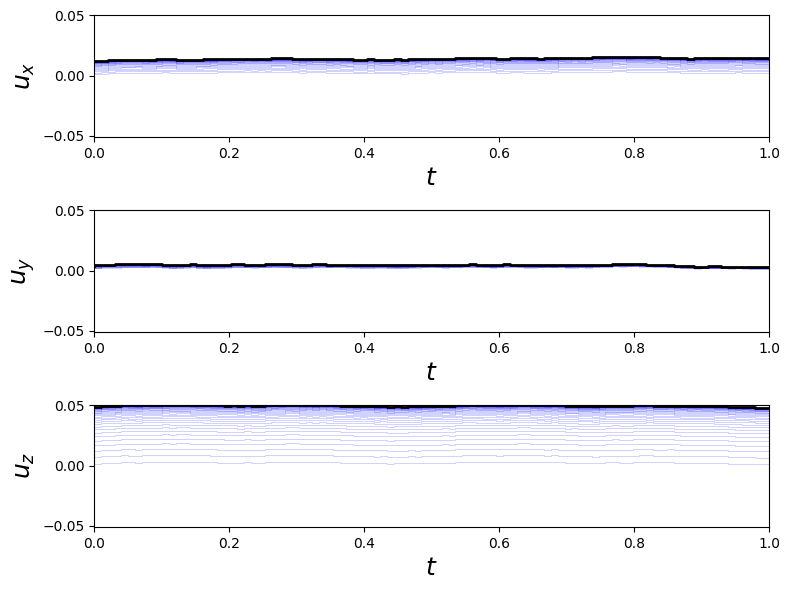

In [12]:
plot_grape_control_fields(times, result.u[:,:,:] / (2 * pi), H_labels, uniform_axes=True);

In [13]:
# target unitary
U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.94714831-0.30764815j -0.02808128-0.0864531j ]
 [ 0.02808128-0.0864531j   0.94714831+0.30764815j]]

In [14]:
# unitary from grape pulse
result.U_f

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.94714831-0.30764815j -0.02808128-0.0864531j ]
 [ 0.02808128-0.0864531j   0.94714831+0.30764815j]]

In [15]:
# target / result overlap
_overlap(U, result.U_f).real, abs(_overlap(U, result.U_f))**2

(1.0000000000000009, 1.0000000000000018)

### Verify correctness of the Hamiltonian pulses by integration

In [16]:
c_ops = []

print(result.H_t)

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 0.]], [Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]], array([0.07391549, 0.07569472, 0.0773225 , 0.08054083, 0.08188946,
       0.08311768, 0.0832313 , 0.0836453 , 0.08198382, 0.08281802,
       0.08414357, 0.08522116, 0.08494145, 0.08231241, 0.0832915 ,
       0.08348159, 0.08386626, 0.08430504, 0.08470025, 0.08611465,
       0.08684894, 0.08721503, 0.08779191, 0.08848146, 0.08812124,
       0.0889265 , 0.08817574, 0.08961032, 0.08958655, 0.08946271,
       0.08741504, 0.08557205, 0.08712725, 0.08777528, 0.08749138,
       0.08622479, 0.08690881, 0.08542174, 0.08531526, 0.08389254,
       0.08385842, 0.0859182 , 0.08369589, 0.08284701, 0.0828877 ,
       0.08424093, 0.08274934, 0.085093  , 0.08559709, 0.08708346,
       0.08900994, 0.08771047, 0.08898582, 0.08891853, 0.09088682,
       0.09156828, 0.09333236, 0.09126637

In [17]:
U_f_numerical = propagator(result.H_t, times, c_ops, args={})

In [18]:

U_f_numerical[-1]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.94714914-0.30763045j -0.02806152-0.08651335j]
 [ 0.02806152-0.08651335j  0.94714914+0.30763045j]]

In [19]:
_overlap(U, U_f_numerical[-1])

0.9999999978327709

# Bloch sphere dynamics

In [20]:
psi0 = basis(2, 0)
e_ops = [sigmax(), sigmay(), sigmaz()]

In [21]:
me_result = mesolve(result.H_t, psi0, times, c_ops, e_ops)

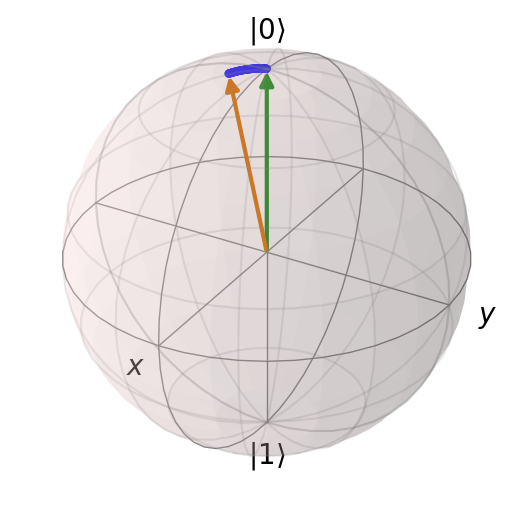

In [22]:
b = Bloch()

b.add_points(me_result.expect)

b.add_states(psi0)
b.add_states(U * psi0)
b.render()
b.show()

# Process tomography

## Ideal gate

In [23]:
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]]
op_label = [["i", "x", "y", "z"]]

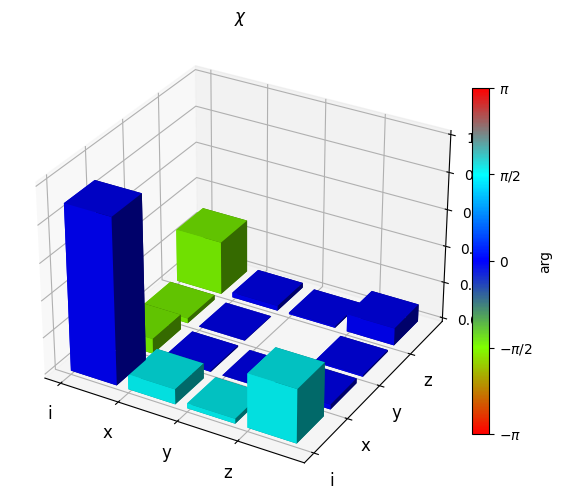

In [24]:
fig = plt.figure(figsize=(8,6))

U_ideal = spre(U) * spost(U.dag())

chi = qpt(U_ideal, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## Gate calculated using GRAPE

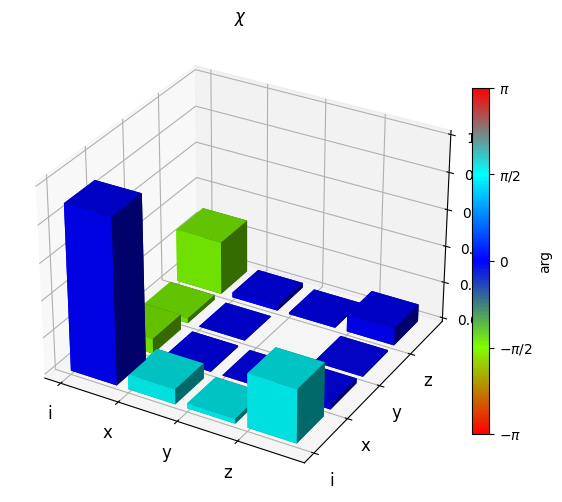

In [25]:
fig = plt.figure(figsize=(8,6))

U_ideal = spre(result.U_f) * spost(result.U_f.dag())

chi = qpt(U_ideal, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## Versions

In [26]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.7.1.dev0+ff9ada8
Numpy,1.24.0
SciPy,1.9.3
matplotlib,3.6.2
Cython,0.29.32
Number of CPUs,8
BLAS Info,OPENBLAS
IPython,8.7.0
Python,"3.11.0 (v3.11.0:deaf509e8f, Oct 24 2022, 14:43:23) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
